# Does the inclusion of cryptocurrency-based indicies extend the MV frontier of a well diversified equity investor?

In [94]:
import os
import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
import scipy
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Specifiy the absolute directory path
directory_path = os.path.abspath('data/raw')
directory_path = os.path.abspath('data/interim')
directory_path = os.path.abspath('data/processed')
absolute_path = os.path.join(os.getcwd(), 'data\processed')
os.makedirs(    directory_path, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
start_date = '2017-11-09'
end_date = '2023-09-30'

In [96]:
import pandas_datareader.data as web  # module for reading datasets directly from the web
from pandas_datareader.famafrench import get_available_datasets
import pickleshare
datasets = get_available_datasets()
print('No. of datasets:{0}'.format(len(datasets)))
#datasets # comment out if you want to see all the datasets
df_12_industry = [dataset for dataset in datasets if '12' in dataset and 'Industry' in dataset]
print(df_12_industry)


No. of datasets:297
['12_Industry_Portfolios', '12_Industry_Portfolios_Wout_Div', '12_Industry_Portfolios_daily']


In [97]:
#Take [2] to extract 12_DAILY using above the start date on the next trading day after the 22.11 (rets from dont have an initial value)
ds_industry = web.DataReader(df_12_industry[2],'famafrench',start=start_date,end=end_date)
print(type(ds_industry))
ds_industry.keys()

c:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)
c:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)


<class 'dict'>


dict_keys([0, 1, 'DESCR'])

In [98]:
#Line to look for what dataset each key from dict_keys corresponds to
print(ds_industry['DESCR'])

12 Industry Portfolios daily
----------------------------

This file was created by CMPT_IND_RETS_DAILY using the 202309 CRSP database. It contains value- and equal-weighted returns for 12 industry portfolios. The portfolios are constructed at the end of June. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French

  0 : Average Value Weighted Returns -- Daily (1481 rows x 12 cols)
  1 : Average Equal Weighted Returns -- Daily (1481 rows x 12 cols)


In [99]:
# I decided to use average EW rets for model simplicity (key = 1)
ds_industry[1].head()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
2017-11-09,0.29,-0.18,0.00,0.65,-0.96,-0.99,0.27,-0.10,0.76,0.63,-0.26,0.15
2017-11-10,1.09,0.41,0.25,-0.41,-0.10,0.34,-0.29,-0.62,0.54,0.37,0.01,0.15
2017-11-13,0.27,0.53,-0.36,-0.82,0.54,-0.07,-0.84,0.47,-0.28,-0.44,0.45,-0.50
2017-11-14,0.53,-0.27,-0.56,-3.35,-0.72,-0.07,-0.78,1.16,0.16,-1.23,0.29,-0.58
2017-11-15,-0.40,-0.83,-0.61,-1.31,-1.32,-0.63,0.18,-0.97,-0.12,0.49,0.06,-0.53


In [100]:
# Dictionary --> Dataframe --> CSV
industry_df = pd.DataFrame(ds_industry[1])
industry_df.to_csv(r'data\raw\12_Industry_Portfolios_Daily_Raw.csv', index=True)
industry_df = pd.read_csv(r'data\raw\12_Industry_Portfolios_Daily_Raw.csv')
industry_df.head()

,Date,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,2017-11-09,0.29,-0.18,0.00,0.65,-0.96,-0.99,0.27,-0.10,0.76,0.63,-0.26,0.15
1,2017-11-10,1.09,0.41,0.25,-0.41,-0.10,0.34,-0.29,-0.62,0.54,0.37,0.01,0.15
2,2017-11-13,0.27,0.53,-0.36,-0.82,0.54,-0.07,-0.84,0.47,-0.28,-0.44,0.45,-0.50
3,2017-11-14,0.53,-0.27,-0.56,-3.35,-0.72,-0.07,-0.78,1.16,0.16,-1.23,0.29,-0.58
4,2017-11-15,-0.40,-0.83,-0.61,-1.31,-1.32,-0.63,0.18,-0.97,-0.12,0.49,0.06,-0.53


In [101]:
# Grab data for 3 main cryptocurrencies - BTC, ETH, XRP
# Compute MV variance frontier and CML for each 

In [102]:
data = yf.download('XRP-USD', start=start_date, end=end_date, progress=False) 
data.to_csv(r'data\raw\XRP-USD_Raw.csv', index=False)

close_df = pd.read_csv(r'data\raw\XRP-USD_Raw.csv', parse_dates=False)
close_df = close_df[['Adj Close']]
close_df.to_csv(r'data/interim/XRP-USD_Close.csv', index=False)
close_df.head()

,Adj Close
0,0.217488
1,0.206483
2,0.210430
3,0.197339
4,0.203442


In [103]:
data = yf.download('ETH-USD', start=start_date, end=end_date, progress=False) 
data.to_csv(r'data\raw\ETH-USD_Raw.csv', index=False)

close_df = pd.read_csv(r'data\raw\ETH-USD_Raw.csv', parse_dates=False)
close_df = close_df[['Adj Close']]
close_df.to_csv(r'data/interim/ETH-USD_Close.csv', index=False)
close_df.head()

,Adj Close
0,320.884003
1,299.252991
2,314.681000
3,307.907990
4,316.716003


In [104]:
data = yf.download('BTC-USD', start=start_date, end=end_date, progress=False) 
data.to_csv(r'data\raw\BTC-USD_Raw.csv', index=False)

close_df = pd.read_csv(r'data\raw\BTC-USD_Raw.csv', parse_dates=False)
close_df = close_df[['Adj Close']]
close_df.to_csv(r'data/interim/BTC-USD_Close.csv', index=False)
close_df.head()

,Adj Close
0,7143.580078
1,6618.140137
2,6357.600098
3,5950.069824
4,6559.490234


In [105]:
close_df = pd.read_csv('data/interim/XRP-USD_Close.csv', parse_dates=True)
# Computing logarithmic returns on the crypto index
close_df['XRP Returns'] = close_df['Adj Close'].pct_change().dropna()
returns_csv_path = 'data/interim/XRP_Returns.csv'
close_df[['XRP Returns']].to_csv(returns_csv_path, index=False)
close_df.head()

,Adj Close,XRP Returns
0,0.217488,NaN
1,0.206483,-0.050600
2,0.210430,0.019115
3,0.197339,-0.062211
4,0.203442,0.030927


In [106]:
close_df = pd.read_csv('data/interim/BTC-USD_Close.csv', parse_dates=True)
# Computing logarithmic returns on the crypto index
close_df['BTC Returns'] = close_df['Adj Close'].pct_change().dropna()
returns_csv_path = 'data/interim/BTC_Returns.csv'
close_df[['BTC Returns']].to_csv(returns_csv_path, index=False)
close_df.head()

,Adj Close,BTC Returns
0,7143.580078,NaN
1,6618.140137,-0.073554
2,6357.600098,-0.039368
3,5950.069824,-0.064101
4,6559.490234,0.102422


In [107]:
close_df = pd.read_csv('data/interim/ETH-USD_Close.csv', parse_dates=True)
# Computing logarithmic returns on the crypto index
close_df['ETH Returns'] = close_df['Adj Close'].pct_change().dropna()
returns_csv_path = 'data/interim/ETH_Returns.csv'
close_df[['ETH Returns']].to_csv(returns_csv_path, index=False)
close_df.head()

,Adj Close,ETH Returns
0,320.884003,NaN
1,299.252991,-0.067411
2,314.681000,0.051555
3,307.907990,-0.021523
4,316.716003,0.028606


In [108]:
BTC_df = pd.read_csv('data/interim/BTC_Returns.csv', header='infer').dropna()
ETH_df = pd.read_csv('data/interim/ETH_Returns.csv', header='infer').dropna()
XRP_df = pd.read_csv('data/interim/XRP_Returns.csv', header='infer').dropna()
cleaned_industry_df = pd.read_csv(r'data\raw\12_Industry_Portfolios_Daily_Raw.csv')
result_df = pd.concat([cleaned_industry_df, BTC_df*100, ETH_df*100, XRP_df*100], axis=1)
result_df.to_csv('data\processed\Combined_Processed_Data.csv', index=False)
result_df.head()

,Date,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,BTC Returns,ETH Returns,XRP Returns
0,2017-11-09,0.29,-0.18,0.00,0.65,-0.96,-0.99,0.27,-0.10,0.76,0.63,-0.26,0.15,NaN,NaN,NaN
1,2017-11-10,1.09,0.41,0.25,-0.41,-0.10,0.34,-0.29,-0.62,0.54,0.37,0.01,0.15,-7.355415,-6.741069,-5.060049
2,2017-11-13,0.27,0.53,-0.36,-0.82,0.54,-0.07,-0.84,0.47,-0.28,-0.44,0.45,-0.50,-3.936756,5.155507,1.911532
3,2017-11-14,0.53,-0.27,-0.56,-3.35,-0.72,-0.07,-0.78,1.16,0.16,-1.23,0.29,-0.58,-6.410128,-2.152342,-6.221070
4,2017-11-15,-0.40,-0.83,-0.61,-1.31,-1.32,-0.63,0.18,-0.97,-0.12,0.49,0.06,-0.53,10.242240,2.860599,3.092652


In [20]:
#we should probably move these 3 functions to a separate .py file so we can call upon them when necessary

def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = scipy.optimize.minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

Expected returns, varcov matrix

In [21]:
def optimal_weights(n_points, er, cov):
    """
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

In [111]:
# Paramater values
rf = 0.001
n_points = 200

In [112]:
# Load the processed data for analysis, choose the RF rate
ind_crypto = pd.read_csv('data\processed\Combined_Processed_Data.csv', header=0, index_col=0)/100
industry_SR = sharpe_ratio(ind_crypto, rf, 260).sort_values()
industry_SR

Telcm         -0.012262
Hlth           0.027025
XRP Returns    0.104784
Enrgy          0.149033
Durbl          0.151491
NoDur          0.156168
Money          0.210115
Utils          0.214157
Chems          0.234967
Other          0.270010
Manuf          0.270524
BTC Returns    0.280633
ETH Returns    0.282831
Shops          0.306541
BusEq          0.318542
dtype: float64

In [22]:
def plot_ef(n_points, er, cov, er2, cov2):
    """
    Plots two multi-asset efficient frontiers on the same graph
    """
    # First efficient frontier
    weights = optimal_weights(n_points, er, cov)  # Assuming optimal_weights is implemented
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef1 = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })

    # Second efficient frontier
    weights2 = optimal_weights(n_points, er2, cov2)  # Assuming optimal_weights is implemented
    rets2 = [portfolio_return(w, er2) for w in weights2]
    vols2 = [portfolio_vol(w, cov2) for w in weights2]
    ef2 = pd.DataFrame({
        "Returns": rets2,
        "Volatility": vols2
    })

    # Plotting both efficient frontiers on the same graph
    ax = ef1.plot.line(x="Volatility", y="Returns", style='.-', label='Industry portfolio without cryptocurrencies')
    ef2.plot.line(x="Volatility", y="Returns", style='.-', ax=ax, label='Industry portfolio with cryptocurrencies')
    
    ax.set_xlim(left=0.0114, right=0.016)
    ax.set_ylim(top=0.12)

    # Customize the plot as needed
    plt.title("Efficient Frontier Comparison")
    plt.xlabel("Volatility")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [114]:
er = annualize_rets(ind_crypto, 260)
cov = ind_crypto.cov()
industry = ["NoDur", "Durbl",	"Manuf", "Enrgy", "Chems", "BusEq", "Telcm", "Utils", "Shops", "Hlth ", "Money", "Other"]
industry_and_crypto = ["NoDur", "Durbl", "Manuf", "Enrgy", "Chems", "BusEq", "Telcm", "Utils", "Shops", "XRP Returns", "BTC Returns", "ETH Returns"]

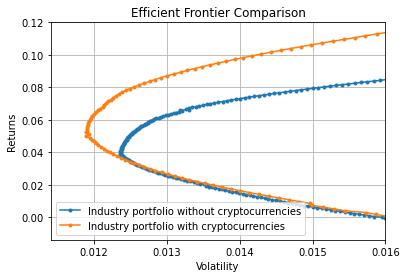

In [115]:
industry_crypto_combined_plots = plot_ef(n_points, er[industry], cov.loc[industry, industry], er[industry_and_crypto], cov.loc[industry_and_crypto, industry_and_crypto])

## Does the inclusion of cryptocurrency-based indicies extend the MV frontier of a well diversified equity investor?

In [21]:
import numpy as np
import pandas as pd
import scipy 
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Paramaters
rf = 0.001 # Risk-free rate 
periods_per_year = 260 # Number of trading days per year


To use own data --> requires one CSV with returns for benchmark. 
* One CSV with returns for additional returns that one would consider adding into the portfolio
* First column in both of these files need to be the date column

Importing benchmark & crypto portfolio created in data_grabbing.ipynb, creating the list of names of industry portfolios and names of cryptocurrency pairs to be put inside the optimizer

In [22]:
test_industry = pd.read_csv('../data/raw/industry_returns.csv')
test_crypto = pd.read_csv('../data/raw/crypto_returns.csv')
crypto = test_crypto.columns.values.tolist()[1:]

# Defining lists used later:
industry = test_industry.columns.values.tolist()[1:]
industry_and_crypto = industry + crypto

print(industry)
print(industry_and_crypto)

['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth ', 'Money', 'Other']
['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth ', 'Money', 'Other', 'BTC-USD', 'ETH-USD', 'XRP-USD']


Double check on dates of available data (excluding the weekend price data characteristic of cryptocurrency pairs)

In [13]:
# Convert the indices to sets
dates_in_industry = set(test_industry.index)
dates_in_crypto = set(test_crypto.index)

# Find dates that are only in crypto_returns
dates_only_in_crypto_returns = dates_in_crypto - dates_in_industry

# Convert to a sorted list for easier viewing or further processing
dates_only_in_crypto_returns = sorted(list(dates_only_in_crypto_returns))

# Print or inspect the dates
print(dates_only_in_crypto_returns)

[1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 164

Creating the main dataframe consisting of all columns of ordinary returns from both .csv files joined based on the respective dates

In [14]:
ind_crypto = pd.merge(test_industry, test_crypto, on='Date') # this is an inner join --> only includes values that has dates in both df:s
ind_crypto = ind_crypto.set_index('Date')
ind_crypto.to_csv('../data/processed/industry_crypto_returns.csv')
ind_crypto

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,BTC-USD,ETH-USD,XRP-USD
Date,,,,,,,,,,,,,,,
2017-11-10,0.0109,0.0041,0.0025,-0.0041,-0.0010,0.0034,-0.0029,-0.0062,0.0054,0.0037,0.0001,0.0015,-0.073554,-0.067411,-0.050600
2017-11-13,0.0027,0.0053,-0.0036,-0.0082,0.0054,-0.0007,-0.0084,0.0047,-0.0028,-0.0044,0.0045,-0.0050,0.102422,0.028606,0.030927
2017-11-14,0.0053,-0.0027,-0.0056,-0.0335,-0.0072,-0.0007,-0.0078,0.0116,0.0016,-0.0123,0.0029,-0.0058,0.011626,0.066037,0.031375
2017-11-15,-0.0040,-0.0083,-0.0061,-0.0131,-0.0132,-0.0063,0.0018,-0.0097,-0.0012,0.0049,0.0006,-0.0053,0.102444,-0.012659,0.014922
2017-11-16,0.0199,0.0258,0.0167,0.0073,0.0142,0.0219,0.0183,0.0037,0.0214,0.0201,0.0132,0.0182,0.076023,-0.007298,0.066450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,-0.0102,0.0035,-0.0019,0.0185,0.0066,-0.0006,-0.0102,-0.0010,-0.0011,-0.0089,0.0046,-0.0001,0.001586,0.004725,0.006117
2023-09-26,-0.0039,-0.0168,-0.0131,-0.0058,-0.0116,-0.0135,-0.0178,-0.0230,-0.0125,0.0171,-0.0114,-0.0088,-0.003089,0.003207,-0.007425
2023-09-27,-0.0037,0.0021,0.0099,0.0323,-0.0050,0.0074,0.0097,-0.0076,0.0070,-0.0007,-0.0012,0.0027,0.005167,0.002557,-0.004208


### Defining functions needed to compute the efficient frontier:

In [15]:
#we should probably move these 3 functions to a separate .py file so we can call upon them when necessary

def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = opt.minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

In [16]:
def optimal_weights(n_points, er, cov):
    """
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

Computing the sharpe ratios of all chosen instruments (which are merged inside of the ind_crypto dataframe)

In [23]:
# Load the processed data for analysis, choose the RF rate
industry_SR = sharpe_ratio(ind_crypto, rf, periods_per_year).sort_values()
industry_SR

ETH-USD   -0.029154
Telcm     -0.019576
Hlth       0.035539
XRP-USD    0.192375
Enrgy      0.217357
Durbl      0.223441
NoDur      0.226161
BTC-USD    0.301355
Money      0.310830
Utils      0.315226
Chems      0.353182
Other      0.396179
Manuf      0.399403
Shops      0.448222
BusEq      0.479068
dtype: float64

Computing efficient froniters

In [24]:
def plot_ef(n_points, er, cov, er2, cov2):
    """
    Plots two multi-asset efficient frontiers on the same graph
    """
    # First efficient frontier
    weights = optimal_weights(n_points, er, cov)  # Assuming optimal_weights is implemented
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef1 = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })

    # Second efficient frontier
    weights2 = optimal_weights(n_points, er2, cov2)  # Assuming optimal_weights is implemented
    rets2 = [portfolio_return(w, er2) for w in weights2]
    vols2 = [portfolio_vol(w, cov2) for w in weights2]
    ef2 = pd.DataFrame({
        "Returns": rets2,
        "Volatility": vols2
    })

    # Plotting both efficient frontiers on the same graph
    ax = ef1.plot.line(x="Volatility", y="Returns", style='.-', label='Industry portfolio without cryptocurrencies')
    ef2.plot.line(x="Volatility", y="Returns", style='.-', ax=ax, label='Industry portfolio with cryptocurrencies')
    
    ax.set_xlim(left=0.0114, right=0.016)
    ax.set_ylim(bottom=0.0, top=0.12)

    # Customize the plot as needed
    plt.title("Efficient Frontier Comparison")
    plt.xlabel("Volatility")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [25]:
er = annualize_rets(ind_crypto, periods_per_year)
cov = ind_crypto.cov()

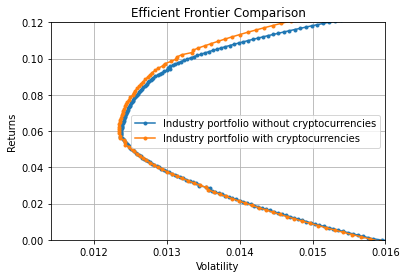

In [26]:
industry_crypto_combined_plots = plot_ef(200, er[industry], cov.loc[industry, industry], er[industry_and_crypto], cov.loc[industry_and_crypto, industry_and_crypto]) 
#maybe use matplotlib here? It makes more sense to calculate all values then plot it? 